<a href="https://colab.research.google.com/github/smlra-kjsce/PyTorch-101/blob/main/Sine%20Function%20Approximation%20in%20PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Define some hyperparameters

In [15]:
LR = 1e-6
MAX_EPOCH = 10
BATCH_SIZE = 512

## Defining our model to approximate sine curve

In [16]:
class SineApproximator(nn.Module):
    def __init__(self):
        super(SineApproximator, self).__init__()
        self.regressor = nn.Sequential(nn.Linear(1, 1024),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(1024, 1024),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(1024, 1))
    def forward(self, x):
        output = self.regressor(x)
        return output

    ## Since I have inherited nn.Module, backward() function is already implemented and I don't need to define it again.

In [17]:
X = np.random.rand(10**6) * 2 * np.pi
y = np.sin(X)

X_train, X_val, y_train, y_val = map(torch.tensor, train_test_split(X, y, test_size=0.2))
train_dataloader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=BATCH_SIZE,
                              pin_memory=True, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_val.unsqueeze(1), y_val.unsqueeze(1)), batch_size=BATCH_SIZE,
                            pin_memory=True, shuffle=True)

model = SineApproximator().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_mean_func = nn.MSELoss(reduction="mean")

Text(0.5, 1.0, 'Total Dataset for Sine Approximation')

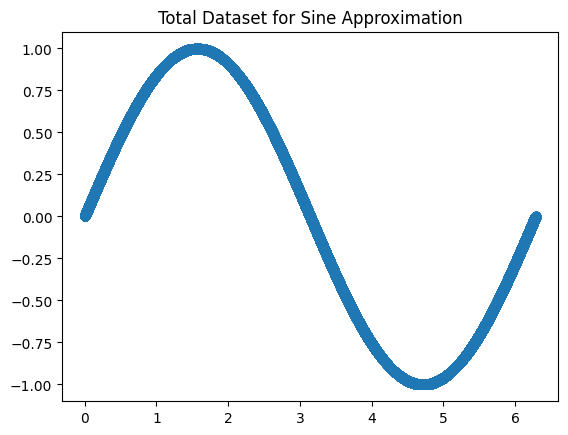

In [18]:
plt.scatter(X,y)
plt.title('Total Dataset for Sine Approximation')

## Training our model

In [19]:
train_loss_list = list()
val_loss_list = list()
for epoch in range(MAX_EPOCH):
    print("epoch %d / %d" % (epoch+1, MAX_EPOCH))
    model.train()
    # training loop
    temp_loss_list = list()
    for X_train, y_train in train_dataloader:
        X_train = X_train.type(torch.float32).to(device)
        y_train = y_train.type(torch.float32).to(device)

        optimizer.zero_grad()

        score = model(X_train)
        loss = loss_mean_func(input=score, target=y_train)
        loss.backward()

        optimizer.step()

        temp_loss_list.append(loss.detach().cpu().numpy())
    
    temp_loss_list = list()
    for X_train, y_train in train_dataloader:
        X_train = X_train.type(torch.float32).to(device)
        y_train = y_train.type(torch.float32).to(device)

        score = model(X_train)
        loss = loss_mean_func(input=score, target=y_train)

        temp_loss_list.append(loss.detach().cpu().numpy())
    
    train_loss_list.append(np.average(temp_loss_list))

    # validation
    model.eval()
    
    temp_loss_list = list()
    for X_val, y_val in val_dataloader:
        X_val = X_val.type(torch.float32).to(device)
        y_val = y_val.type(torch.float32).to(device)

        score = model(X_val)
        loss = loss_mean_func(input=score, target=y_val)

        temp_loss_list.append(loss.detach().cpu().numpy())
    
    val_loss_list.append(np.average(temp_loss_list))

    print("\ttrain loss: %.5f" % train_loss_list[-1])
    print("\tval loss: %.5f" % val_loss_list[-1])

epoch 1 / 10
	train loss: 0.10168
	val loss: 0.10159
epoch 2 / 10
	train loss: 0.07688
	val loss: 0.07683
epoch 3 / 10
	train loss: 0.05542
	val loss: 0.05537
epoch 4 / 10
	train loss: 0.03629
	val loss: 0.03626
epoch 5 / 10
	train loss: 0.02133
	val loss: 0.02131
epoch 6 / 10
	train loss: 0.01170
	val loss: 0.01168
epoch 7 / 10
	train loss: 0.00607
	val loss: 0.00605
epoch 8 / 10
	train loss: 0.00299
	val loss: 0.00298
epoch 9 / 10
	train loss: 0.00142
	val loss: 0.00142
epoch 10 / 10
	train loss: 0.00067
	val loss: 0.00067


## Plotting Loss

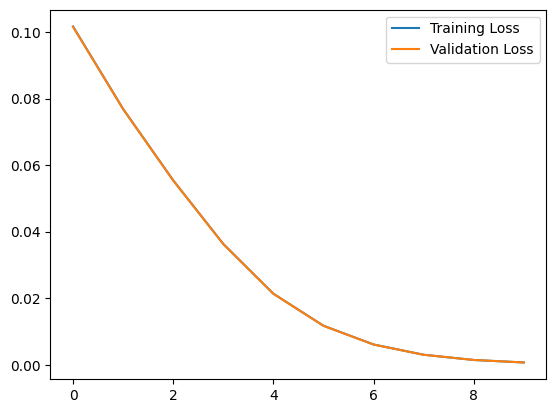

In [20]:
train_plot = plt.plot(train_loss_list, label="Training Loss")
val_plot = plt.plot(val_loss_list, label="Validation Loss")
plt.legend(loc="upper right")

## Time for prediction!

In [21]:
model.eval()
prediction = model(X_val)

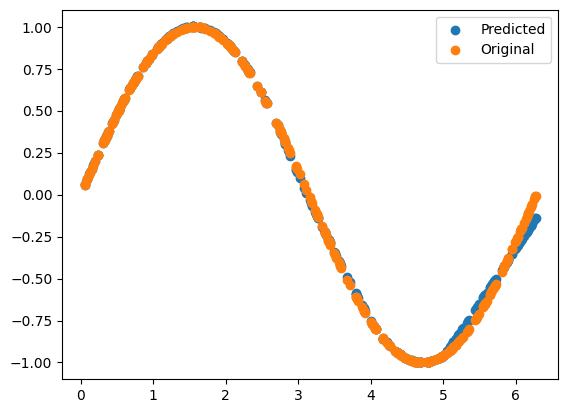

In [30]:
predicted = plt.scatter(X_val.cpu(), prediction.detach().cpu())
original = plt.scatter(X_val.cpu(), y_val.cpu())
plt.legend((predicted, original), ("Predicted", "Original"));

### So, here we can see that our neural network was able to approximate sine function very well.

## State_dict of model and optimizer

In [29]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
regressor.0.weight 	 torch.Size([1024, 1])
regressor.0.bias 	 torch.Size([1024])
regressor.2.weight 	 torch.Size([1024, 1024])
regressor.2.bias 	 torch.Size([1024])
regressor.4.weight 	 torch.Size([1, 1024])
regressor.4.bias 	 torch.Size([1])


## Saving model using save() and state_dict()

In [25]:
PATH = './sine.pt'
torch.save(model.state_dict(), PATH)

## Loading model using load() and load_state_dict()

In [26]:
device = torch.device("cuda")
model = SineApproximator()
model.load_state_dict(torch.load(PATH))
model.to(device)
model.eval()

SineApproximator(
  (regressor): Sequential(
    (0): Linear(in_features=1, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=1, bias=True)
  )
)

## Trying pre-trained model for inference/training

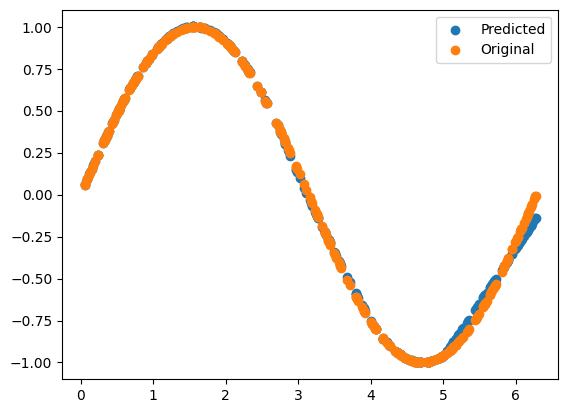

In [28]:
new_pred = model(X_val)
pred = plt.scatter(X_val.cpu(), new_pred.detach().cpu())
original = plt.scatter(X_val.cpu(), y_val.cpu())
plt.legend((pred, original), ("Predicted", "Original"));